[ok] combined rows: 1199983 -> combined_apo_p_cont_dihedral_distance.csv


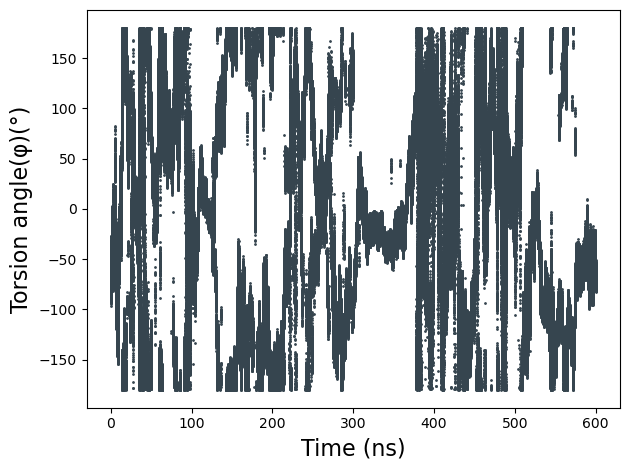

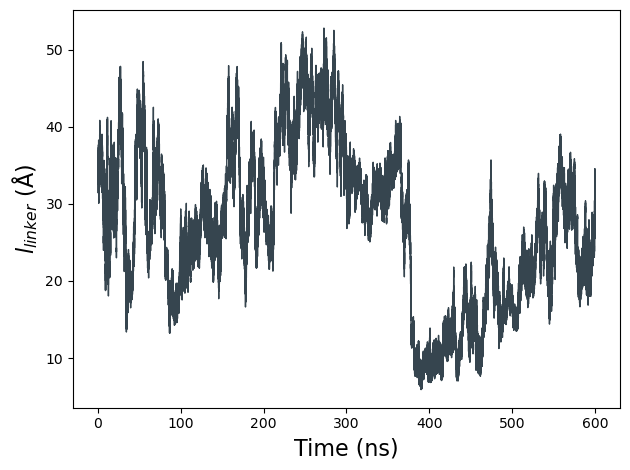

,timestep,dihedral,distance,time_shifted,time_ns
0,50010500,-34.100040,33.791209,0.0,0.0000
1,50011000,-34.957711,33.493738,500.0,0.0005
2,50011500,-34.313237,33.405236,1000.0,0.0010
3,50012000,-33.681469,33.917071,1500.0,0.0015
4,50012500,-35.121499,34.105235,2000.0,0.0020


,timestep,dihedral,distance,time_shifted,time_ns
1199978,649998000,-63.728779,28.916933,599987500.0,599.9875
1199979,649998500,-62.772957,28.761391,599988000.0,599.9880
1199980,649999000,-62.483352,29.034983,599988500.0,599.9885
1199981,649999500,-63.338676,28.569581,599989000.0,599.9890
1199982,650000000,-57.147552,29.104350,599989500.0,599.9895


<Figure size 640x480 with 0 Axes>

In [1]:
%matplotlib inline
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from pathlib import Path

RUN_DIR = "apo_p_hills"   
PREFIX  = "apo_p"       

# go into the folder
os.chdir(RUN_DIR)


def _file_key(name: str):
    import re
    if name.startswith(f"{PREFIX}_meta_cont"):
        m = re.search(rf"{PREFIX}_meta_cont(\d+)\.", name)
        return (1, int(m.group(1)) if m else 10**9, name)
    elif name.startswith(f"{PREFIX}_meta."):
        return (0, 0, name)
    else:
        return (2, 10**9, name)

FILES_IN_ORDER = sorted(
    [p.name for p in Path(".").glob(f"{PREFIX}_meta*.colvars.meta-dihedral.hills.traj")],
    key=_file_key
)

ZERO_REF = 50010500.0      # reference timestep to make zero
TIMESTEPS_PER_NS = 1e6     # adjust if your time units differ

# ==== READ & COMBINE ====
dfs = []
for fp in FILES_IN_ORDER:
    p = Path(fp)
    if not p.exists():
        print(f"[warn] not found: {fp}")
        continue
    df = pd.read_csv(
        p,
        comment="#",
        delim_whitespace=True,
        header=None,
        usecols=[0, 1, 2],
        names=["timestep", "dihedral", "distance"],
        engine="python",
    )
    for col in ["timestep", "dihedral", "distance"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(subset=["timestep", "dihedral", "distance"])
    dfs.append(df)

if len(dfs) == 0:
    raise SystemExit("No valid .traj files found.")

combined = pd.concat(dfs, ignore_index=True)
combined = combined.sort_values("timestep").reset_index(drop=True)

# Shift time and convert to ns
combined["time_shifted"] = combined["timestep"] - ZERO_REF
combined["time_ns"] = combined["time_shifted"] / TIMESTEPS_PER_NS

# Optional: save to CSV
combined.to_csv(f"combined_{PREFIX}_cont_dihedral_distance.csv", index=False)
print(f"[ok] combined rows: {len(combined)} -> combined_{PREFIX}_cont_dihedral_distance.csv")

# helper to remove scientific notation on x-axis
def no_sci_xaxis(ax):
    fmt = ScalarFormatter(useOffset=False)
    fmt.set_scientific(False)
    ax.xaxis.set_major_formatter(fmt)

# ==== PLOTS ====

# torsion (φ) vs time with dots
plt.figure()
plt.plot(combined["time_ns"], combined["dihedral"], ".", markersize=2, color='#36454F')
plt.xlabel("Time (ns)", fontsize=16)
plt.ylabel('Torsion angle(φ)(°)', fontsize=16)
no_sci_xaxis(plt.gca())
plt.tight_layout()
plt.show()

# linker end-to-end distance vs time (line)
plt.figure()
plt.plot(combined["time_ns"], combined["distance"], linewidth=1, color='#36454F')
plt.xlabel("Time (ns)", fontsize=16)
plt.ylabel(r'$l_{\mathit{linker}}$ (Å)', fontsize=16)
no_sci_xaxis(plt.gca())
plt.tight_layout()
plt.show()
plt.savefig('hills_apo_p.png', format='png', dpi=300)
# quick look at combined data
display(combined.head(5))
display(combined.tail(5))
